In [1]:
import pandas as pd
import seaborn as sns
from scipy.stats import norm, randint
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler

In [2]:
df = pd.read_csv('./data/fetal-health.csv')
df.sample(10)

baseline value  accelerations  fetal_movement  uterine_contractions  \
1320           128.0          0.007           0.008                 0.005   
1318           125.0          0.002           0.014                 0.006   
1662           106.0          0.001           0.000                 0.011   
424            143.0          0.000           0.000                 0.002   
722            143.0          0.000           0.017                 0.000   
451            135.0          0.007           0.003                 0.000   
965            133.0          0.003           0.000                 0.004   
2034           129.0          0.000           0.001                 0.006   
297            148.0          0.000           0.012                 0.000   
1909           130.0          0.002           0.002                 0.008   

      light_decelerations  severe_decelerations  prolongued_decelerations  \
1320                0.005                   0.0                     0.001   
1318                0.008                   0.0                     0.000   
1662                0.000                   0.0                     0.000   
424                 0.000                   0.0                     0.000   
722                 0.000                   0.0                     0.000   
451                 0.000                   0.0                     0.000   
965                 0.004                   0.0                     0.000   
2034                0.005                   0.0                     0.002   
297                 0.000                   0.0                     0.000   
1909                0.008                   0.0                     0.002   

      abnormal_short_term_variability  mean_value_of_short_term_variability  \
1320                             19.0                                   2.4   
1318                             18.0                                   2.7   
1662                             63.0                                   0.6   
424                              65.0                                   0.6   
722                              70.0                                   0.3   
451                              58.0                                   0.6   
965                              28.0                                   1.6   
2034                             67.0                                   3.3   
297                              75.0                                   0.2   
1909                             64.0                                   2.5   

      percentage_of_time_with_abnormal_long_term_variability  ...  \
1320                                                0.0       ...   
1318                                                0.0       ...   
1662                                                0.0       ...   
424                                                 7.0       ...   
722                                                50.0       ...   
451                                                 3.0       ...   
965                                                 0.0       ...   
2034                                                0.0       ...   
297                                                84.0       ...   
1909                                                0.0       ...   

      histogram_min  histogram_max  histogram_number_of_peaks  \
1320           67.0          174.0                        7.0   
1318           53.0          178.0                       10.0   
1662           95.0          125.0                        1.0   
424           129.0          158.0                        4.0   
722           142.0          155.0                        1.0   
451            70.0          165.0                        5.0   
965            57.0          153.0                        5.0   
2034           63.0          192.0                        7.0   
297           145.0          152.0                        1.0   
1909           50.0          2

### EDA

In [3]:
df.isna().sum().sum()

0

<Axes: xlabel='percentage_of_time_with_abnormal_long_term_variability', ylabel='abnormal_short_term_variability'>

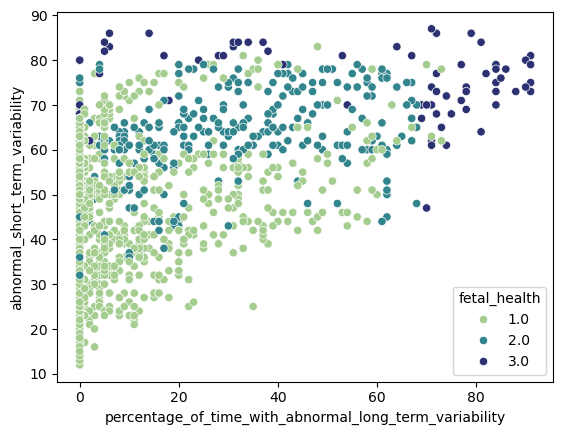

In [4]:
sns.scatterplot(data=df,
                x='percentage_of_time_with_abnormal_long_term_variability',
                y='abnormal_short_term_variability',
                hue='fetal_health',
                palette='crest')

In [5]:
X = df.drop(columns='fetal_health')
y = df.fetal_health

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [6]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
log_reg = LogisticRegression(solver='newton-cg')
log_reg.fit(X_train, y_train)
log_reg.score(X_test, y_test)

0.8849765258215962

In [8]:
forest = RandomForestClassifier(class_weight='balanced')
forest.fit(X_train, y_train)
forest.score(X_test, y_test)

0.931924882629108

In [9]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
gbc.score(X_test, y_test)

0.9272300469483568

In [10]:
cv = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(),
    param_distributions={
        'n_estimators': randint(50, 500),
        'min_samples_split': randint(2, 5),
        'max_depth': randint(3, 8)
    },
    n_jobs=2,
    cv=3,
    scoring='recall_micro',
    n_iter=20,
)
cv.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_iter=20,
                   n_jobs=2,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x143d44bd0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x143d446d0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x143d3bd50>},
                   scoring='recall_micro')

In [11]:
confusion_matrix(y_test, cv.predict(X_test))

array([[325,   4,   3],
       [ 15,  41,   3],
       [  2,   2,  31]])

In [12]:
print(classification_report(y_test, cv.predict(X_test)))

              precision    recall  f1-score   support

         1.0       0.95      0.98      0.96       332
         2.0       0.87      0.69      0.77        59
         3.0       0.84      0.89      0.86        35

    accuracy                           0.93       426
   macro avg       0.89      0.85      0.87       426
weighted avg       0.93      0.93      0.93       426

